## [Calibrating Probabilities (scikit-learn docs)](https://scikit-learn.org/stable/modules/calibration.html#calibration)

Great question! `CalibratedClassifierCV` addresses a **critical but often overlooked problem**: many ML models produce **poorly calibrated probabilities**.

## The Problem: Uncalibrated Probabilities

When you call `predict_proba()`, you expect:
- `0.8` probability → should be correct ~80% of the time
- `0.3` probability → should be correct ~30% of the time

**But many models don't work this way!**

```python
# Example of uncalibrated model
model.predict_proba(X)  # Returns 0.95
# But in reality, predictions with 0.95 are only correct 70% of the time!
```

Common culprits:
- **Naive Bayes**: Notoriously overconfident (pushes probabilities toward 0 and 1)
- **SVMs**: Not designed for probabilities at all
- **Decision Trees/Random Forests**: Often miscalibrated
- **Boosted models** (like AdaBoost): Can be overconfident

## Why This Matters

**Calibrated probabilities are critical when**:
1. **Decision thresholds matter** - You need to adjust cutoffs (e.g., classify as positive only if prob > 0.7)
2. **Probability interpretation** - Stakeholders need to trust "80% confident"
3. **Cost-sensitive decisions** - Medical diagnosis, fraud detection where false positives/negatives have different costs
4. **Ranking by confidence** - Prioritizing cases by probability

## What Platt Scaling Does

```python
method='sigmoid'  # Platt scaling
```

**Platt scaling** trains a **logistic regression** on top of your model's raw scores to fix the calibration:

```
Raw model score → Logistic regression → Calibrated probability
```

**How it works internally**:
1. Uses cross-validation to get out-of-fold predictions from your base model
2. Treats those predictions as features
3. Trains a simple logistic regression: `sigmoid(A * score + B)`
4. The sigmoid parameters A and B "stretch" probabilities to match true frequencies

## Why Use CV Here

```python
cv=cv  # Same CV strategy as your hyperparameter tuning
```

The calibration needs **unbiased probability estimates** to learn from, so:
- Fits your `best_estimator` multiple times (one per fold)
- Gets predictions on held-out data
- Uses those to train the calibration layer
- **Final model**: Retrains `best_estimator` on all data + calibration layer

## Why Calibrate AFTER Tuning

```python
calibrated_model = CalibratedClassifierCV(
    best_estimator,  # Already tuned!
    ...
)
```

**Critical insight**: 
- Hyperparameter tuning finds the best **discriminative** model (best at separating classes)
- Calibration fixes **probability estimates** without changing discrimination
- Tuning calibration parameters would be wasting computation - they don't affect core performance

## Alternative: Isotonic Calibration

```python
method='isotonic'  # More flexible, but needs more data
```

- **Sigmoid/Platt**: Assumes monotonic sigmoid relationship (works well with smaller data)
- **Isotonic**: Non-parametric, more flexible (better with large datasets, >1000 samples)

## When to Skip Calibration

**Don't calibrate if**:
- You only care about `predict()` (class labels), not probabilities
- You're using logistic regression (already calibrated!)
- You're using properly tuned neural networks (usually well-calibrated)

---

**In your pipeline**: You're likely using a model that benefits from calibration (SVM, tree-based, or Naive Bayes), and you need trustworthy probabilities for threshold-based decisions or interpretation.

Want me to show how to **evaluate calibration** (calibration curves, Brier score) to verify it's helping?

---
---


# Evaluating Calibration

Here are the key methods to verify if calibration is improving your model's probability estimates.

## 1. Calibration Curves (Reliability Diagrams)

The **gold standard** for visualizing calibration:

```python
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_calibration_curve(y_true, y_proba_uncalibrated, y_proba_calibrated):
    """
    Compare calibration before and after
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    
    # Uncalibrated model
    fraction_pos_uncal, mean_pred_uncal = calibration_curve(
        y_true, 
        y_proba_uncalibrated,
        n_bins=10,  # Divide probabilities into 10 bins
        strategy='uniform'  # Equal-width bins
    )
    ax.plot(mean_pred_uncal, fraction_pos_uncal, 's-', 
            label='Before calibration', linewidth=2)
    
    # Calibrated model
    fraction_pos_cal, mean_pred_cal = calibration_curve(
        y_true,
        y_proba_calibrated,
        n_bins=10,
        strategy='uniform'
    )
    ax.plot(mean_pred_cal, fraction_pos_cal, 'o-', 
            label='After calibration', linewidth=2)
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=12)
    ax.set_ylabel('Fraction of Positives', fontsize=12)
    ax.set_title('Calibration Curve', fontsize=14)
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usage in your pipeline
from sklearn.model_selection import cross_val_predict

# Get uncalibrated probabilities (before CalibratedClassifierCV)
y_proba_uncal = cross_val_predict(
    best_estimator,  # Your tuned model before calibration
    X_train,
    y_train,
    cv=cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]  # Get positive class probabilities

# Get calibrated probabilities
y_proba_cal = cross_val_predict(
    calibrated_model,  # After CalibratedClassifierCV
    X_train,
    y_train,
    cv=cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# Plot comparison
plot_calibration_curve(y_train, y_proba_uncal, y_proba_cal)
```

**How to Read Calibration Curves**:

```
Perfect calibration (diagonal line):
- If model predicts 0.4, true rate IS 0.4
- Points should lie on the diagonal

Common problems:
┌─────────────────────────────────────────┐
│ Curve ABOVE diagonal = Underconfident  │
│   Model says 0.3 → Actually 0.5 true   │
│   (too conservative)                    │
└─────────────────────────────────────────┘

┌─────────────────────────────────────────┐
│ Curve BELOW diagonal = Overconfident   │
│   Model says 0.8 → Actually 0.5 true   │
│   (too aggressive - common in NB/SVM)  │
└─────────────────────────────────────────┘

┌─────────────────────────────────────────┐
│ S-shaped curve = Systematic bias       │
│   Pushes probabilities to extremes     │
│   (common in Naive Bayes)              │
└─────────────────────────────────────────┘
```

## 2. Brier Score (Quantitative Measure)

**Brier Score** = Mean squared error between predicted probabilities and true labels:

```python
from sklearn.metrics import brier_score_loss

# Lower is better (0 = perfect, 1 = worst)
brier_uncalibrated = brier_score_loss(y_train, y_proba_uncal)
brier_calibrated = brier_score_loss(y_train, y_proba_cal)

print(f"Brier Score (uncalibrated): {brier_uncalibrated:.4f}")
print(f"Brier Score (calibrated):   {brier_calibrated:.4f}")
print(f"Improvement: {(brier_uncalibrated - brier_calibrated):.4f}")
```

**Interpretation**:
- **Brier = 0.00**: Perfect probabilities
- **Brier = 0.25**: Random guessing (for balanced classes)
- **Brier = 1.00**: Always wrong

**Important**: Calibration can improve Brier score WITHOUT changing accuracy/AUC!

## 3. Expected Calibration Error (ECE)

A more intuitive metric - **average difference between predicted and true frequencies**:

```python
def expected_calibration_error(y_true, y_proba, n_bins=10):
    """
    Calculate Expected Calibration Error
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find samples in this bin
        in_bin = (y_proba >= bin_lower) & (y_proba < bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_proba[in_bin].mean()
            
            # Weighted difference
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

ece_uncal = expected_calibration_error(y_train, y_proba_uncal)
ece_cal = expected_calibration_error(y_train, y_proba_cal)

print(f"ECE (uncalibrated): {ece_uncal:.4f}")
print(f"ECE (calibrated):   {ece_cal:.4f}")
```

**Interpretation**:
- **ECE = 0.00**: Perfect calibration
- **ECE = 0.05**: On average, probabilities are off by 5%
- **ECE > 0.10**: Poorly calibrated

## 4. Complete Evaluation Function

Here's a comprehensive function to evaluate everything at once:

```python
def evaluate_calibration(model_uncal, model_cal, X, y, cv):
    """
    Complete calibration evaluation
    """
    from sklearn.metrics import (brier_score_loss, roc_auc_score, 
                                   accuracy_score, classification_report)
    
    # Get predictions
    y_proba_uncal = cross_val_predict(
        model_uncal, X, y, cv=cv, method='predict_proba', n_jobs=-1
    )[:, 1]
    
    y_proba_cal = cross_val_predict(
        model_cal, X, y, cv=cv, method='predict_proba', n_jobs=-1
    )[:, 1]
    
    y_pred_uncal = cross_val_predict(
        model_uncal, X, y, cv=cv, n_jobs=-1
    )
    
    y_pred_cal = cross_val_predict(
        model_cal, X, y, cv=cv, n_jobs=-1
    )
    
    print("="*60)
    print("CALIBRATION EVALUATION")
    print("="*60)
    
    # Discrimination metrics (should be similar)
    print("\n1. DISCRIMINATION (Separating Classes):")
    print(f"   AUC (uncalibrated): {roc_auc_score(y, y_proba_uncal):.4f}")
    print(f"   AUC (calibrated):   {roc_auc_score(y, y_proba_cal):.4f}")
    print(f"   → Calibration shouldn't change discrimination much")
    
    print(f"\n   Accuracy (uncalibrated): {accuracy_score(y, y_pred_uncal):.4f}")
    print(f"   Accuracy (calibrated):   {accuracy_score(y, y_pred_cal):.4f}")
    
    # Calibration metrics (should improve)
    print("\n2. CALIBRATION (Probability Quality):")
    brier_uncal = brier_score_loss(y, y_proba_uncal)
    brier_cal = brier_score_loss(y, y_proba_cal)
    print(f"   Brier Score (uncalibrated): {brier_uncal:.4f}")
    print(f"   Brier Score (calibrated):   {brier_cal:.4f}")
    print(f"   → Improvement: {(brier_uncal - brier_cal):.4f} (lower is better)")
    
    ece_uncal = expected_calibration_error(y, y_proba_uncal)
    ece_cal = expected_calibration_error(y, y_proba_cal)
    print(f"\n   ECE (uncalibrated): {ece_uncal:.4f}")
    print(f"   ECE (calibrated):   {ece_cal:.4f}")
    print(f"   → Improvement: {(ece_uncal - ece_cal):.4f} (lower is better)")
    
    # Visualize
    print("\n3. CALIBRATION CURVE:")
    plot_calibration_curve(y, y_proba_uncal, y_proba_cal)
    
    return {
        'brier_uncal': brier_uncal,
        'brier_cal': brier_cal,
        'ece_uncal': ece_uncal,
        'ece_cal': ece_cal
    }

# Usage
results = evaluate_calibration(
    best_estimator,      # Before calibration
    calibrated_model,    # After calibration
    X_train,
    y_train,
    cv=cv
)
```

## 5. Probability Histograms

Another useful visualization - **distribution of predicted probabilities**:

```python
def plot_probability_histograms(y_proba_uncal, y_proba_cal):
    """
    See how probabilities are distributed
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Uncalibrated
    axes[0].hist(y_proba_uncal, bins=20, alpha=0.7, edgecolor='black')
    axes[0].set_title('Uncalibrated Probabilities', fontsize=14)
    axes[0].set_xlabel('Predicted Probability')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(0.5, color='red', linestyle='--', label='Decision boundary')
    axes[0].legend()
    
    # Calibrated
    axes[1].hist(y_proba_cal, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axes[1].set_title('Calibrated Probabilities', fontsize=14)
    axes[1].set_xlabel('Predicted Probability')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(0.5, color='red', linestyle='--', label='Decision boundary')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_probability_histograms(y_proba_uncal, y_proba_cal)
```

**What to look for**:
- **Spiky near 0/1**: Model is overconfident (common before calibration)
- **Spread out**: Better calibrated
- **All near 0.5**: Model is uncertain (might be underfitted)

---

## Key Insights

**What calibration DOES**:
✅ Improves Brier score  
✅ Improves ECE  
✅ Makes probabilities trustworthy  
✅ Helps with threshold tuning  

**What calibration DOESN'T change**:
❌ AUC-ROC (discrimination stays the same)  
❌ Accuracy at default threshold (usually)  
❌ Precision/Recall curves  

**The bottom line**: If you see **ECE drop** and **Brier score improve** without hurting AUC, calibration worked!

Want me to show how to use these calibrated probabilities for **cost-sensitive decision-making** or **optimal threshold selection**?

---
### Calibration curve (also known as reliability diagram) visualization.

class sklearn.calibration.CalibrationDisplay(prob_true, prob_pred, y_prob, *, estimator_name=None, pos_label=None)[source]


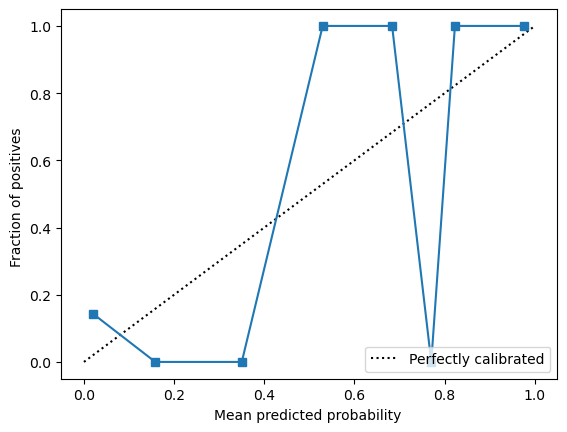

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay

X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()